In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy import ndimage
from scipy.spatial import distance

### Outline

In Part A, you will be implementing a function for 2D convoulution. You will be implementing the following functions:

- Convolution functions:
    - Zero Padding
    - Convolve Image

#### Zero-Padding

Zero-padding adds zeros around the border of an image:

The main benefits of padding are the following:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.


Implement the <code>zero_pad</code> function which will pad the image. Use <code>np.pad</code> to do this (Look up the documentation to figure out the arguments for padding)

In [ ]:
help(np.pad)

In [ ]:
def zero_pad(X, pad):
    """
    Arguments:
    X -- python numpy array of shape (n_H, n_W) representing a an image
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    """
    X_pad = np.pad(X, (pad,pad), 'constant', constant_values=(0, 0))
    return X_pad

Shape of x_pad:  (7, 7)


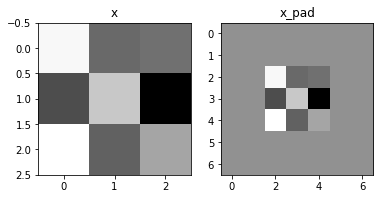

In [ ]:
np.random.seed(1)
x = np.random.randn(3, 3)
x_pad = zero_pad(x, 2)

print("Shape of x_pad: ", x_pad.shape)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x,cmap='gray')
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad,cmap='gray')

**Expected Output**:
<table>
    <tr>
        <td>
            <strong>x_pad.shape</strong>
        </td>
        <td>
            (7,7)
        </td>
    </tr>

</table>

#### 2D Convolution

In this part, implement a 2D convolution, in which you apply the filter to aa image. This will be used to build a convolutional unit, which: 

- Takes an input image 
- Applies a filter at every position of the input
- Outputs another image (usually of different size)

In [ ]:
def conv2D(inp, F, pad, stride):
    """
    Arguments:
    inp -- output activations of the previous layer, numpy array of shape (n_H, n_W)
    F -- Filter, numpy array of shape (f, f)
    pad -- integer
    stride -- integer
    """
    
    # Retrieve dimensions from inp's shape
    (n_H, n_W) = inp.shape
    
    # Retrieve dimensions from F's shape
    (f_H, f_W) = F.shape
    
    ########## START CODE HERE ##########
    # Compute the dimensions of the CONV output volume (Hint: use int() to floor the output)
    new_H = int((n_H -f_H + (2*pad))/stride + 1)
    new_W = int((n_W -f_W + (2*pad))/stride + 1)  
    
    # Create inp_pad by padding inp
    if pad != 0:
        inp = zero_pad(inp,pad)
        
    # Initialize the output volume Z with zeros
    Z = np.zeros((new_H,new_W))
    
    # Iterate over inp and compute its Convolved output (z) and store it appropriately in Z.
    for y in range(0,inp.shape[1],stride):
        if y > inp.shape[1] - f_H: 
            break
        for x in range(0,inp.shape[0],stride):
            if x > inp.shape[0] - f_W: 
                break
            Z[x,y] = (F * inp[x:x + f_W, y:y + f_H]).sum()
                
            

    ########## END CODE HERE ##########
    
    return Z

In [ ]:
print(duck_gray.shape)
conv2D(duck_gray,h_filter,1,1).shape

(496, 661)


(496, 661)

#### Edge Detection

(496, 661, 3)


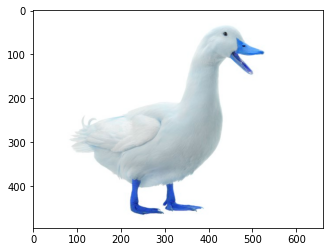

In [ ]:
# read and display duck.jpg (Hint: for reading image see cv2.imread)
path = './duck.jpg'
duck= cv2.imread(path)
print(duck.shape)
plt.imshow(duck)


(496, 661)


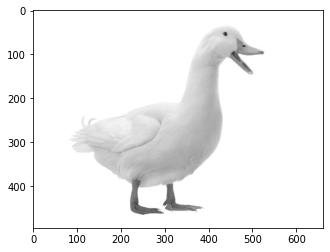

In [ ]:
# convert duck to grayscale (Hint: see cv2.cvtColor)
duck_gray= cv2.cvtColor(duck,cv2.COLOR_BGR2GRAY)
print(duck_gray.shape)
plt.imshow(duck_gray,cmap='gray')

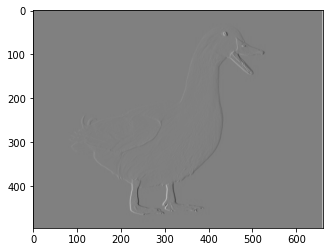

In [ ]:
# Initialize sobel horizontal edge filter
h_filter= np.array([
                    [+1,0,-1],
                    [+2,0,-2],
                    [+1,0,-1]
])

#Use your Conv2D filter to get horizontal edges and display them.
convolved = conv2D(duck_gray, h_filter, 1, 1)
plt.imshow(convolved,cmap='gray')

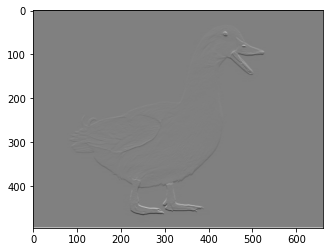

In [ ]:
# Initialize sobel vertical edge filter
v_filter= np.array([
           [+1,+2,+1],
           [0,0,0],
           [-1,-2,-1]
])

# Use your Conv2D filter to get vertical edges and display them.
convolved1 = conv2D(duck_gray, v_filter, 1, 1)
plt.imshow(convolved1,cmap='gray')




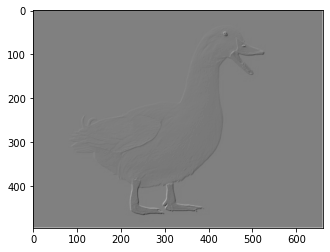

In [ ]:
# combine horizontal and vertical edges and display the final results
plt.imshow(convolved1 + convolved + duck_gray,cmap='gray')

#### Filter Bank

In this part you will make a filter bank for skin textures given in skins folder and then use those to classify 'unknown.jpg'. You will perform the following steps:

- Read skin images and convert them to grayscale.
- Resize the images to 64x64. (Hint: see cv2.resize).
- Initialize any 6 filters. This will be your filter bank. See slide 60 of Lec3 to see which filters can be used.
- Create a 6D feature vector for each image (See Lec3 slides for reference) using window size of 8. (Use your Conv2D function for this).
- Display each feature vector as an image i.e. use plt.imshow.
- Do the above steps for unknown.jpg and calculate it's feature vector.
- Calculate and display the equilidean distance of unknown.jpg's feature with each of skin's feature vector.
- Predict the class name of unknown.jpg based on the euclidean distances calculated in previous step.

In [ ]:
#filters
filters = [
    [[0,0,0],
    [0,-1,0], #horizonatal edges
    [0,0,0]],

    [[0,1,0],
    [0,-1,0], #vertical edges
    [0,0,0]],
    
    [[0,0,-1], #diagonal vertical edges
     [0,1,0],
     [0,0,0]],
    
    [[-1,0,0], #diagonalhorizonatal edges
     [0,1,0],
     [0,0,0]],
    
    [[-5,1,-5],
     [-5,1,-5], #vertical black stripes with white stripe at center
     [-5,1,-5]],
    
    [[-5,1,1],
     [1,-5,1],  #diagonal black stripes
     [1,1,-5]]
    
]

In [ ]:
#TODO
#reading ,resizing and converting textures to grayscale
skins = ['cheetah','giraffe','jaguar','leopard','tiger']
skins_matrix = []
for i in skins:
  path = './skins/' + i +'.jpg'
  skins_matrix.append(cv2.resize(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2GRAY),(64,64)))


In [ ]:
skins_feature_matrix = []
for i in skins_matrix:
    feature_vector=[]
    for j in filters:
        feature_vector.append(conv2D(i[:8,:8],np.array(j),1,1))
    skins_feature_matrix.append(feature_vector)

skins_feature_matrix = np.array(skins_feature_matrix)   

rows :skins ['cheetah', 'giraffe', 'jaguar', 'leopard', 'tiger']
columns :filters


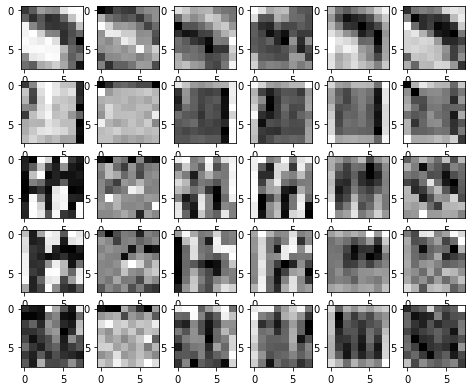

In [ ]:
#plot features
fig = plt.figure(figsize=(8,8))
count = 0
for index,i in enumerate(skins_feature_matrix):
    title = skins[index]
    for index2,j in enumerate(i):
        ax = fig.add_subplot(6,6,count+1)
        plt.imshow(j,cmap='gray')
        count+=1
print("rows :skins",skins)
print("columns :filters")
plt.show()


In [ ]:
#load and resizing images
path = './unknown.jpg'
unknown_img = cv2.resize(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2GRAY),(64,64))
img_feature_matrix = []
for i in filters:
    img_feature_matrix.append(conv2D(unknown_img[:8,:8],np.array(i),1,1))
img_feature_matrix = np.array(img_feature_matrix)

filters


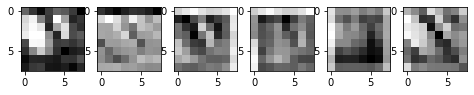

In [ ]:
#plot features
fig = plt.figure(figsize=(8,8))
count = 0
for index,i in enumerate(img_feature_matrix):
    ax = fig.add_subplot(1,6,count+1)
    plt.imshow(i,cmap='gray')
    count+=1

In [ ]:
import math
distance = []
#calculating distances
for index,i in enumerate(skins_feature_matrix):
    distance.append( np.mean(( (img_feature_matrix[index] - skins_feature_matrix[index])**2)**0.5))

#predict
print('predicted value is ',skins[np.argmin(distance)])

predicted value is  cheetah
